# 11.11. Learning Rate Scheduling

So far we primarily focused on optimization algorithms for how to update the weight vectors rather than on the rate at which they are being updated. Nonetheless, adjusting the learning rate is often just as important as the actual algorithm. There are a number of aspects to consider:

Most obviously the magnitude of the learning rate matters. If it is too large, optimization diverges, if it is too small, it takes too long to train or we end up with a suboptimal result. We saw previously that the condition number of the problem matters (see e.g., Section 11.6 for details). Intuitively it is the ratio of the amount of change in the least sensitive direction vs. the most sensitive one.

Secondly, the rate of decay is just as important. If the learning rate remains large we may simply end up bouncing around the minimum and thus not reach optimality. Section 11.5 discussed this in some detail and we analyzed performance guarantees in Section 11.4. In short, we want the rate to decay, but probably more slowly than 
 
 which would be a good choice for convex problems.

Another aspect that is equally important is initialization. This pertains both to how the parameters are set initially (review Section 4.8 for details) and also how they evolve initially. This goes under the moniker of warmup, i.e., how rapidly we start moving towards the solution initially. Large steps in the beginning might not be beneficial, in particular since the initial set of parameters is random. The initial update directions might be quite meaningless, too.

Lastly, there are a number of optimization variants that perform cyclical learning rate adjustment. This is beyond the scope of the current chapter. We recommend the reader to review details in [Izmailov et al., 2018], e.g., how to obtain better solutions by averaging over an entire path of parameters.

Given the fact that there is a lot of detail needed to manage learning rates, most deep learning frameworks have tools to deal with this automatically. In the current chapter we will review the effects that different schedules have on accuracy and also show how this can be managed efficiently via a learning rate scheduler.

## 11.11.1. Toy Problem

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.132, train acc 0.950, test acc 0.905


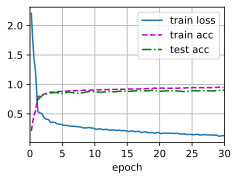

In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 11.11.2. Schedulers

In [3]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

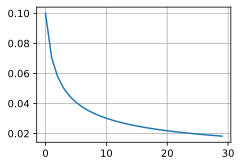

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.280, train acc 0.897, test acc 0.882


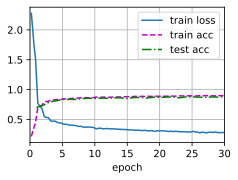

In [6]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## 11.11.3. Policies

While we cannot possibly cover the entire variety of learning rate schedulers, we attempt to give a brief overview of popular policies below. Common choices are polynomial decay and piecewise constant schedules. Beyond that, cosine learning rate schedules have been found to work well empirically on some problems. Lastly, on some problems it is beneficial to warm up the optimizer prior to using large learning rates.

### 11.11.3.1. Factor Scheduler

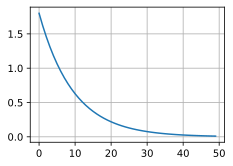

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### 11.11.3.2. Multi Factor Scheduler

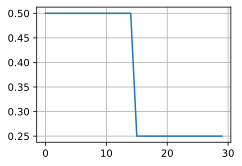

In [8]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

train loss 0.190, train acc 0.929, test acc 0.899


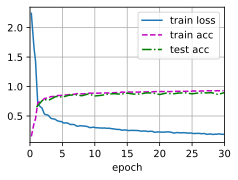

In [9]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 11.11.3.3. Cosine Scheduler

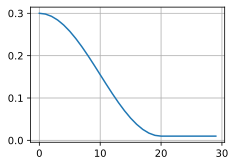

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.167, train acc 0.939, test acc 0.909


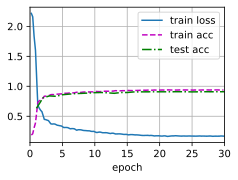

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 11.11.3.4. Warmup

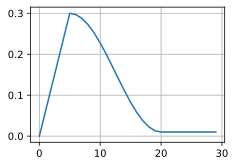

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.194, train acc 0.929, test acc 0.896


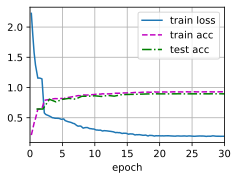

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## 11.11.4. Summary
Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model.

A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.

Cosine schedulers are popular for some computer vision problems. See e.g., GluonCV for details of such a scheduler.

A warmup period before optimization can prevent divergence.

Optimization serves multiple purposes in deep learning. Besides minimizing the training objective, different choices of optimization algorithms and learning rate scheduling can lead to rather different amounts of generalization and overfitting on the test set (for the same amount of training error).